In [3]:
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import product


In [1]:
class Dummy_obj:
    def __init__(self, onnx, vnnlib, n_splits, ot, st, bt, res_o, res_s, res_b):
        self.onnx, self.vnnlib, self.n_splits = onnx, vnnlib, int(n_splits)
        self.ot, self.st, self.bt = float(ot), float(st), float(bt)
        self.res_o, self.res_s, self.res_b = res_o, res_s, res_b
    def __str__(self):
        return f"Instance: {self.onnx}, {self.vnnlib}, {self.n_splits}, {self.res_o}, {self.res_b}, {self.res_s}, {self.ot}, {self.bt}, {self.st}"

In [2]:
def load_csv(file):
    with open(file) as f:
        f.readline()
        rows = []
        for l in f:
#             onnx,vnnlib,strategy,mask,n_splits,original_r,original_t,splitted_r,splitted_t,baseline_r,baseline_t
            fileds = l.split(',')
            assert len(fileds)==11
            if fileds[4] == "SKIPPED":
                rows.append( Dummy_obj(fileds[0], fileds[1], -1, -1, -1, -1, -1, -1, -1) )
                continue
            rows.append( Dummy_obj(fileds[0], fileds[1], fileds[4], 
                                   fileds[6], fileds[8], fileds[10], 
                                   fileds[5], fileds[7], fileds[9]) )
    return (file.stem, rows)
            

In [7]:
exp1_path = Path("/Users/linhan/relusplitter/experiment/results/exp1")
results = []
for f in exp1_path.iterdir():
    if f.suffix != ".csv":
        continue
    if "marabou" in f.stem:
        continue
    if "mnist" not in f.stem:
        continue
    results.append(load_csv(f))
    print(f.stem)

mnist_fc~nnenum~stable~random~1
mnist_fc~neuralsat~stable~random~1
mnist_fc~abcrown~stable~random~1


In [33]:
nns   = []
props = []
epss  = ["0.03", "0.05"]

In [34]:
# check for conflicting verification results

for d1,d2,d3 in zip(*[i[1] for i in results]):
    res = [d1.res_o, d2.res_o, d3.res_o]
    verified_res = [i for i in res if i in ["sat", "unsat"]]
    if len(set(verified_res)) > 1:
        print(res)
    assert d1.onnx == d2.onnx == d3.onnx
    assert d1.vnnlib == d2.vnnlib == d3.vnnlib
    if d1.onnx not in nns:
        nns.append(d1.onnx)
    if d1.vnnlib not in props:
        props.append(d1.vnnlib)

print(nns)
print(props)

['mnist-net_256x2', 'mnist-net_256x4', 'mnist-net_256x6']
['prop_0_0.03', 'prop_1_0.03', 'prop_2_0.03', 'prop_3_0.03', 'prop_4_0.03', 'prop_5_0.03', 'prop_6_0.03', 'prop_7_0.03', 'prop_8_0.03', 'prop_9_0.03', 'prop_10_0.03', 'prop_11_0.03', 'prop_12_0.03', 'prop_13_0.03', 'prop_14_0.03', 'prop_0_0.05', 'prop_1_0.05', 'prop_2_0.05', 'prop_3_0.05', 'prop_4_0.05', 'prop_5_0.05', 'prop_6_0.05', 'prop_7_0.05', 'prop_8_0.05', 'prop_9_0.05', 'prop_10_0.05', 'prop_11_0.05', 'prop_12_0.05', 'prop_13_0.05', 'prop_14_0.05']


In [35]:
# drop skipped instances
filtered_res = []
for n,dps in results:
    dps_ = [dp for dp in dps if dp.res_o in ["sat", "unsat"]]
    filtered_res.append((n, dps_))
    print(len(dps)-len(dps_))

31
5
26


In [51]:
for fname, dps in filtered_res:
    table = {nn:{eps:[0,0] for eps in epss} for nn in nns}
    for dp in dps:
        # filter inconsistent verification result
        veri_ans = [dp.res_o, dp.res_b, dp.res_s]
        veri_ans = list(set([i for i in veri_ans if i in ["sat", "unsat"]]))
        if len(veri_ans)>1:
            print(fname, dp)
            continue
        if dp.res_o =="sat":
            continue
        
        assert any((i in dp.vnnlib) for i in epss)
        eps = "0.03" if "0.03" in dp.vnnlib else "0.05"
        split_slowdown    = dp.st/dp.ot
        baseline_slowdown = dp.bt/dp.ot
        
        
        table[dp.onnx][eps][0] += split_slowdown
        table[dp.onnx][eps][1] += 1
    
    print(fname)
    for nn in nns:
        print(f"\t{nn}")
        for eps in epss:
            total, count = table[nn][eps]
            avg = None
            if count != 0:
                avg = total/count
            print(f"\t{eps}\t{avg}\t{count}")
        

mnist_fc~nnenum~stable~random~1
	mnist-net_256x2
	0.03	22.117947715824215	12
	0.05	43.27140948333356	7
	mnist-net_256x4
	0.03	173.51248524560245	13
	0.05	6.925189671558788	4
	mnist-net_256x6
	0.03	205.69544993734107	12
	0.05	None	0
mnist_fc~neuralsat~stable~random~1
	mnist-net_256x2
	0.03	1.2887604669233357	12
	0.05	1.1692468187850225	7
	mnist-net_256x4
	0.03	16.31455692444288	14
	0.05	6.5600554280226735	11
	mnist-net_256x6
	0.03	22.92750353206417	14
	0.05	2.47182288572459	10
mnist_fc~abcrown~stable~random~1
	mnist-net_256x2
	0.03	1.2478858250491416	12
	0.05	1.2023641233297706	7
	mnist-net_256x4
	0.03	31.601547467764483	13
	0.05	8.735257322688241	2
	mnist-net_256x6
	0.03	50.601535272753104	12
	0.05	None	0


In [147]:
import matplotlib.lines as mlines
eps_offset = 0.5
instance_offset = 0.1
fontsize=16

mnist_fc~nnenum~stable~random~1
mnist_fc~neuralsat~stable~random~1
mnist_fc~abcrown~stable~random~1


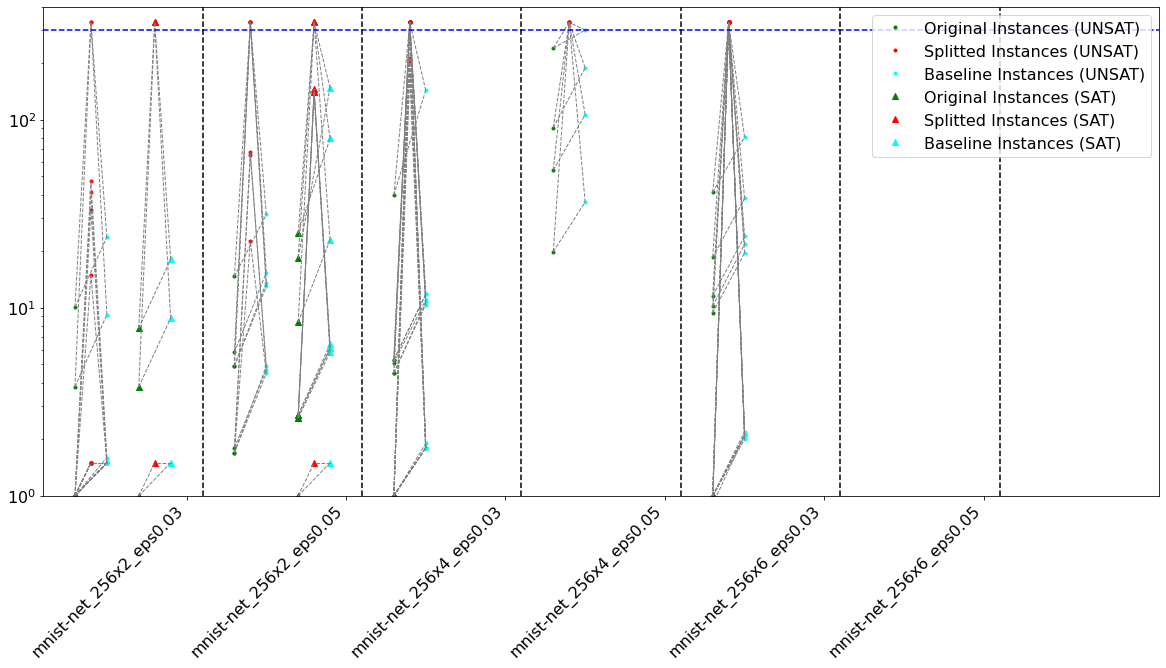

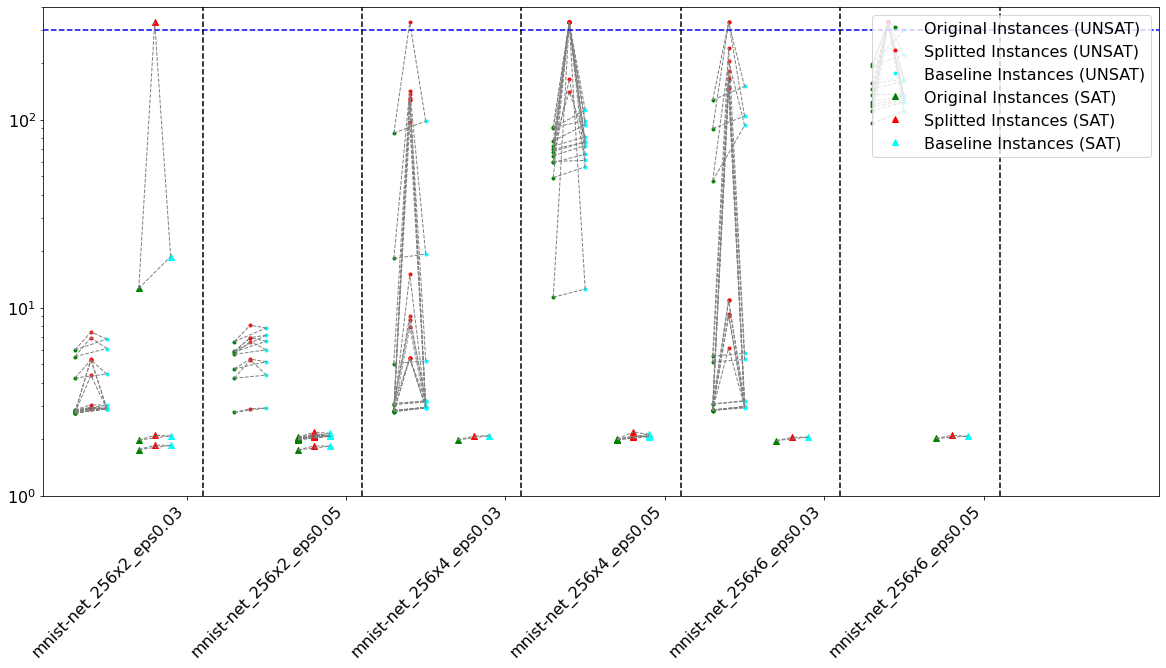

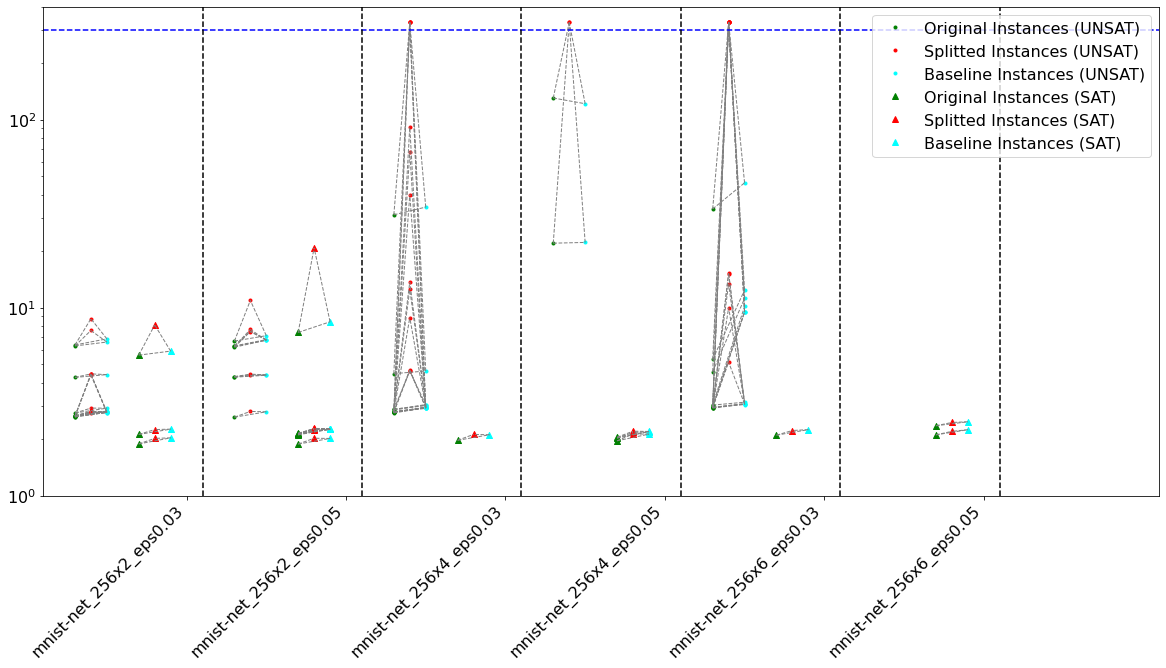

In [149]:
onnx_map = {"mnist-net_256x2":0.2, "mnist-net_256x4":2.2, "mnist-net_256x6":4.2}
eps_offset = { 
                "0.03":0,
                "0.05":1
}
res_offset = {
                "unsat":0,
                "sat"  :0.4 
}

line_width = 1

xmin, xmax = 0, 7
ymin, ymax = 1, 400

timeout = 300


for fname, dps in filtered_res:
    print(fname)
    plt.figure(figsize=(20,9))
    
    
    for dp in dps:
        # filter inconsistent verification result
        veri_ans = [dp.res_o, dp.res_b, dp.res_s]
        if "error" in veri_ans:
            continue
        veri_ans = list(set([i for i in veri_ans if i in ["sat", "unsat"]]))
        if len(veri_ans)>1:
            print(fname, dp)
            continue
            
            
        assert any((i in dp.vnnlib) for i in epss)
        eps = "0.03" if "0.03" in dp.vnnlib else "0.05"
        res = dp.res_o
        x = onnx_map[dp.onnx] + eps_offset[eps] + res_offset[res]
        
        xo,xs,xb = x+0*instance_offset, x+1*instance_offset, x+2*instance_offset
        plt.scatter(xo, dp.ot, color="green", label="Original Instances(UNSAT)", marker='.' if res=='unsat' else '^')
        plt.scatter(xs, dp.st, color="red", label="Splitted Instances(UNSAT)", marker='.' if res=='unsat' else '^')
        plt.scatter(xb, dp.bt, color="cyan", label="Baseline Instances(UNSAT)", marker='.' if res=='unsat' else '^')
        
        plt.plot((xo,xb),(dp.ot, dp.bt), linestyle='--', color='gray', linewidth=line_width)
        plt.plot((xo,xs),(dp.ot, dp.st), linestyle='--', color='gray', linewidth=line_width)
        plt.plot((xb,xs),(dp.bt, dp.st), linestyle='--', color='gray', linewidth=line_width)
        
    
    plt.yscale('log')
    plt.ylim(ymin, ymax)
    plt.xlim(xmin, xmax)
    
    plt.plot([xmin, xmax], [timeout, timeout], linestyle="--", color='blue')
    for x in [1, 2, 3, 4, 5, 6]:
        plt.plot([x, x], [ymin, ymax], linestyle="--", color='black')
        
    
    eps3 = [i+"_eps0.03" for i in onnx_map]
    eps3_x = [onnx_map[i]+eps_offset["0.03"] + 0.7 for i in onnx_map]
    eps5 = [i+"_eps0.05" for i in onnx_map]
    eps5_x = [onnx_map[i]+eps_offset["0.05"] + 0.7 for i in onnx_map]
    plt.yticks(fontsize=fontsize)
    plt.xticks(eps3_x+eps5_x, eps3+eps5, rotation=45, ha='right', fontsize=fontsize)
    
    unsat_o = mlines.Line2D([], [], color='green', marker='.', linestyle='None', label='Original Instances (UNSAT)')
    unsat_s = mlines.Line2D([], [], color='red', marker='.', linestyle='None', label='Splitted Instances (UNSAT)')
    unsat_b = mlines.Line2D([], [], color='cyan', marker='.', linestyle='None', label='Baseline Instances (UNSAT)')
    sat_o = mlines.Line2D([], [], color='green', marker='^', linestyle='None', label='Original Instances (SAT)')
    sat_s = mlines.Line2D([], [], color='red', marker='^', linestyle='None', label='Splitted Instances (SAT)')
    sat_b = mlines.Line2D([], [], color='cyan', marker='^', linestyle='None', label='Baseline Instances (SAT)')
    plt.legend(handles=[unsat_o, unsat_s, unsat_b, sat_o, sat_s, sat_b], loc='upper right', fontsize=fontsize)
    
    
    plt.savefig(fname)


        
    